In [3]:
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
from PIL import Image
import matplotlib.pyplot as plt

# Define the base path to Sentinel-2 data on WEkEO
base_path = "/home/jovyan/eodata/Sentinel-2/MSI/L2A"

# Define date range
start_date = datetime(2020, 6, 1)  # Starting date (YYYY, MM, DD)
end_date = datetime(2020, 6, 30)   # Ending date (YYYY, MM, DD)

# Define the tiles covering the South West UK
south_west_tiles = {"30UUA", "30UUB", "30UVB", "30UVA", "30UWB", "30UWA", "30UXB", "30UXA", "30UVC", "30UWC"}

# Cloud coverage threshold (e.g., max 10%)
max_cloud_coverage = 10.0

# Define a dictionary to store paths of matched images
tile_images = {tile: [] for tile in south_west_tiles}

# Loop through the dates in the specified range
current_date = start_date
while current_date <= end_date:
    # Format year, month, day as strings
    year = current_date.strftime("%Y")
    month = current_date.strftime("%m")
    day = current_date.strftime("%d")
    
    # Define the directory path
    folder_path = os.path.join(base_path, year, month, day)
    
    # Check if the directory exists
    if os.path.isdir(folder_path):
        # Loop through each folder in the day directory
        for folder_name in os.listdir(folder_path):
            # Check if the folder name contains a matching tile code
            for tile in south_west_tiles:
                if tile in folder_name:
                    # Form the path to the .SAFE folder
                    folder_full_path = os.path.join(folder_path, folder_name)
                    metadata_file = os.path.join(folder_full_path, "MTD_MSIL2A.xml")
    
                    if os.path.exists(metadata_file):
                        tree = ET.parse(metadata_file)
                        root = tree.getroot()
    
                        # Extract cloud coverage information
                        cloud_coverage = root.find(".//Cloud_Coverage_Assessment")
                        if cloud_coverage is not None:
                            cloud_coverage_value = float(cloud_coverage.text)
                            if cloud_coverage_value <= max_cloud_coverage:
                                # If cloud coverage is acceptable, look for quick-look .jpg file
                                img_file_name = f"{folder_name[:-5]}-ql.jpg"
                                img_full_path = os.path.join(folder_full_path, img_file_name)
                                if os.path.exists(img_full_path):
                                    tile_images[tile].append(img_full_path)

                    # Found matching tile, move on to next folder
                    break
    
    # Move to the next day
    current_date += timedelta(days=1)

# # Display matched images
# for img_path in matched_images:
#     print(f"Displaying image: {img_path}")
#     with Image.open(img_path) as img:
#         plt.imshow(img)
#         plt.axis('off')
#         plt.show()

In [8]:
for key in tile_images:
    print(f"{key}: {len(tile_images[key])}")

30UVB: 3
30UUA: 2
30UUB: 2
30UVA: 3
30UWA: 3
30UWC: 3
30UVC: 3
30UWB: 2
30UXB: 2
30UXA: 3


Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/01/S2A_MSIL2A_20200601T113331_N0214_R080_T30UVB_20200601T123416.SAFE/S2A_MSIL2A_20200601T113331_N0214_R080_T30UVB_20200601T123416-ql.jpg


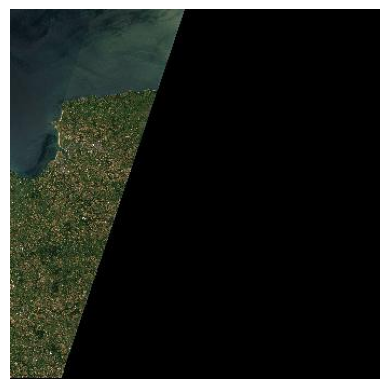

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/23/S2B_MSIL2A_20200623T112119_N0214_R037_T30UVB_20200623T143258.SAFE/S2B_MSIL2A_20200623T112119_N0214_R037_T30UVB_20200623T143258-ql.jpg


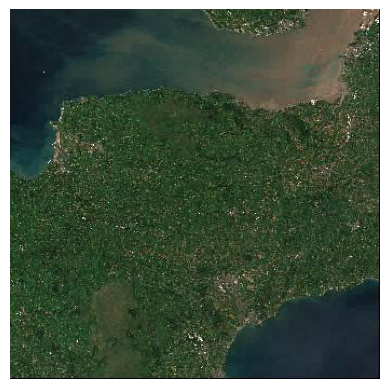

Displaying image: /home/jovyan/eodata/Sentinel-2/MSI/L2A/2020/06/25/S2A_MSIL2A_20200625T110631_N0214_R137_T30UVB_20200625T122333.SAFE/S2A_MSIL2A_20200625T110631_N0214_R137_T30UVB_20200625T122333-ql.jpg


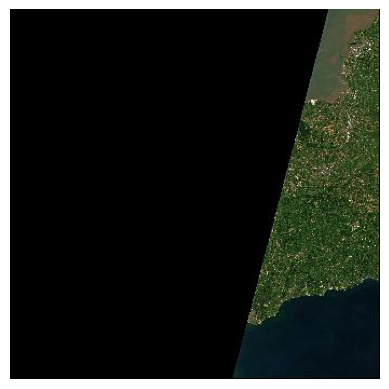

In [9]:
for img_path in tile_images["30UVB"]:
    print(f"Displaying image: {img_path}")
    with Image.open(img_path) as img:
        plt.imshow(img)
        plt.axis('off')
        plt.show()